In [103]:
from matplotlib import pyplot as plt
import numpy as np
import os
os.environ['PATH'] = '/home/grlewis/usr/local/graphviz/bin:' + os.environ['PATH']
import math

In [248]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self, right multiplication
        return self * other

    def __radd__(self, other): # other + self, right addition
        return self + other

    def __rtruediv__(self, other):
        return self ** -1 * other

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self * other ** -1

    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self + -1 * other

    def __pow__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(math.pow(self.data, other.data), (self,), '**')
        def _backward():
            self.grad += other.data * (self.data ** (other.data - 1.0)) * out.grad
        out._backward = _backward
        return out

    def __rpow__(self, other):
        return Value(other) ** self

    def __neg__(self): # -self
        return self * -1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        return out


    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out



    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

In [65]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = a + b
print(c)

Value(data=-1.0)


by defining __add__, we can use the + operator -- it gets overloaded by the class method

In [110]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = a + b
c.label = 'c'
d = a*b
d.label = 'd'
e = d + c
e.label = 'e'
f = Value(-2.0, label='f')
L = e*f
L.label = 'L'

In [111]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('recrod') node for it
        dot.node(name=uid, label=f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}", shape='record')
        if n._op:
            # if this value is the result aof some operation, create an op node for it
            dot.node(name=uid+n._op, label=n._op)
            # and connect this node to is
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [112]:
print(c._prev)

{Value(data=-3.0), Value(data=2.0)}


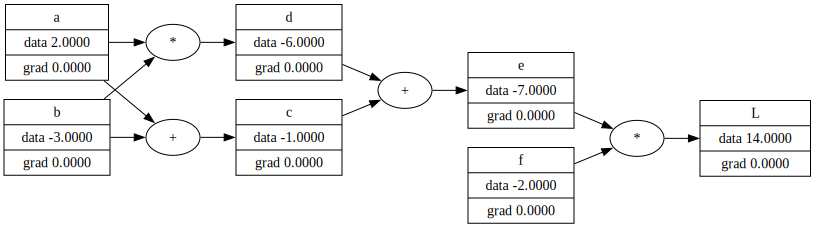

In [113]:
draw_dot(L)

In [114]:
L.grad = 1.0

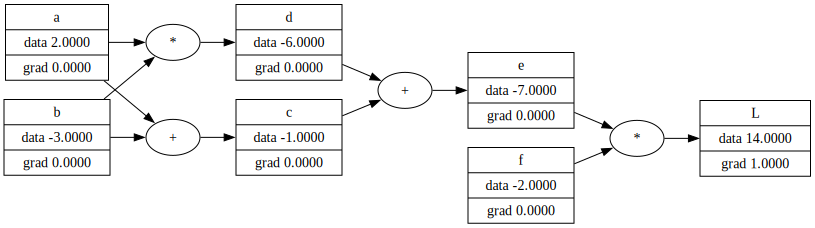

In [115]:
draw_dot(L)

In [116]:
e.grad = f.data
f.grad = e.data

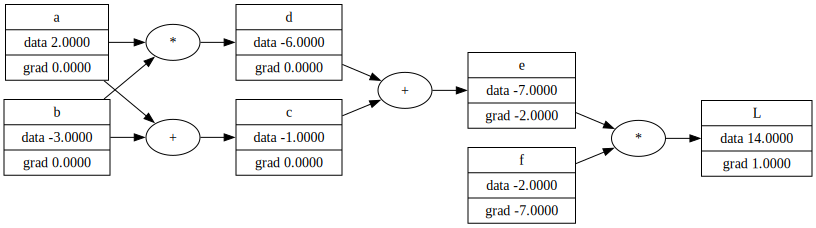

In [117]:
draw_dot(L)

In [118]:
d.grad = e.grad * 1.0
c.grad = e.grad * 1.0

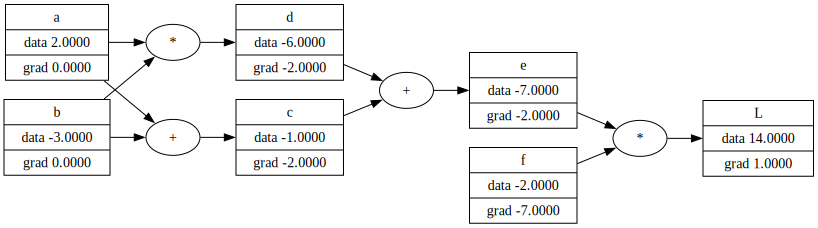

In [119]:
draw_dot(L)

In [120]:
a.grad = b.data * d.grad + 1.0 * c.grad
b.grad = a.data * d.grad + 1.0 * c.grad

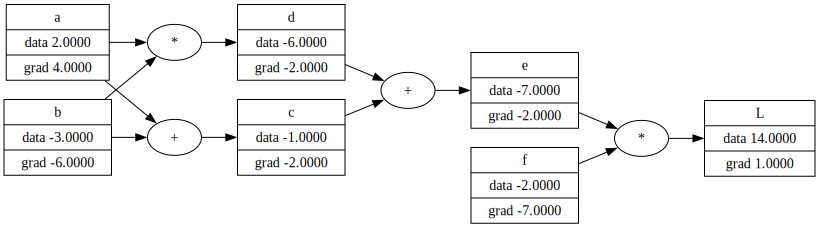

In [121]:
draw_dot(L)

In [122]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad

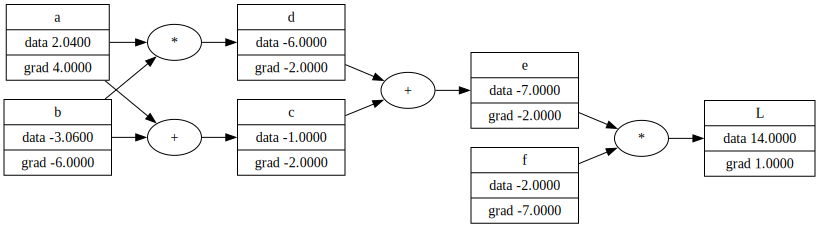

In [123]:
draw_dot(L)

In [124]:
c = a + b
c.label = 'c'
d = a*b
d.label = 'd'
e = d + c
e.label = 'e'
L = e*f
L.label = 'L'

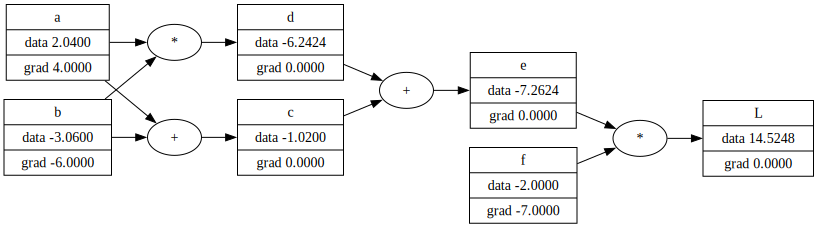

In [125]:
draw_dot(L)

In [184]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b
e.label = 'e'
d = e+c
d.label = 'd'
f = Value(-2.0, label='f')
L = d*f
L.label = 'L'

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(1.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88, label='b')


x1w1 = x1*w1
x1w1.label = 'x1 * w1'
x2w2 = x2*w2
x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1 * w1 + x2 * w2'
n = x1w1x2w2 + b
n.label = 'n'
m = x1w1x2w2.exp()
m.label = 'm'
o = m.tanh() 
o.label = 'o'
o.grad = 1.0

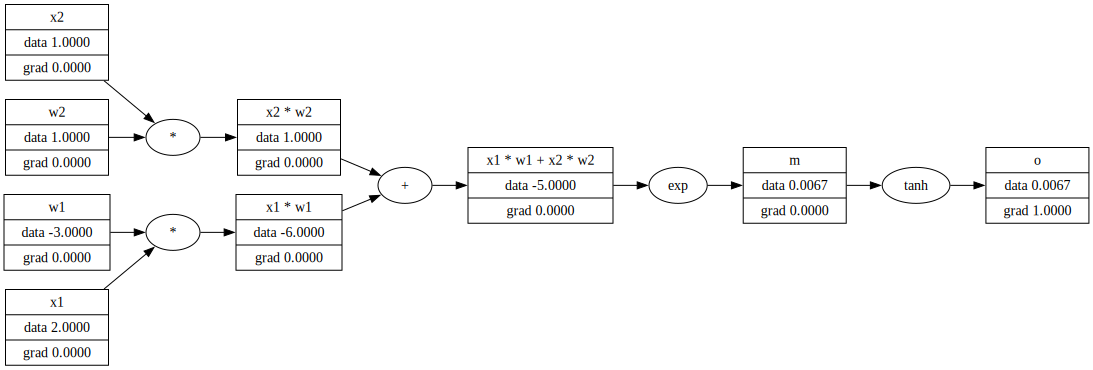

In [185]:
draw_dot(o)

In [141]:
o.grad = 1.0
n.grad = (1 - o.data ** 2)

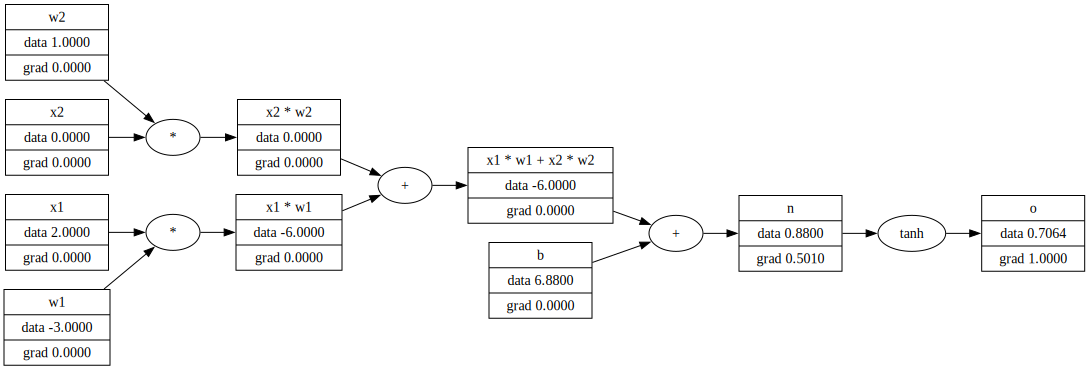

In [142]:
draw_dot(o)

In [143]:
x1w1x2w2.grad = n.grad * 1.0
b.grad = n.grad * 1.0

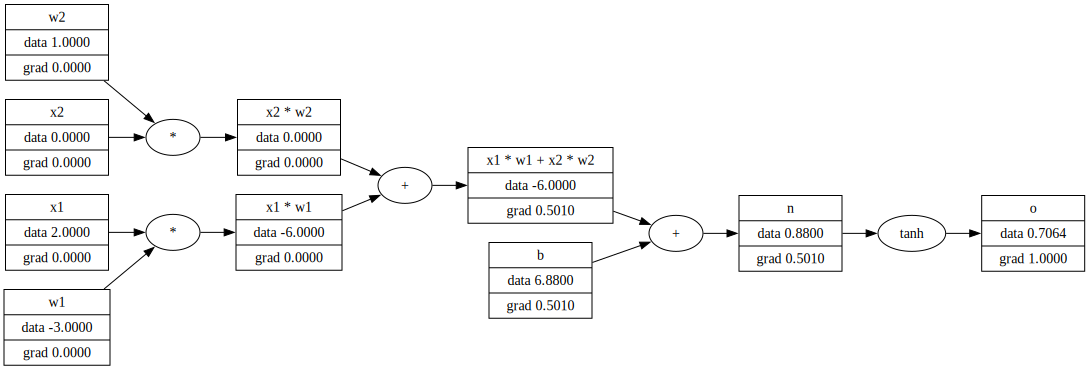

In [144]:
draw_dot(o)

In [145]:
x1w1.grad = x1w1x2w2.grad * 1.0
x2w2.grad = x1w1x2w2.grad * 1.0

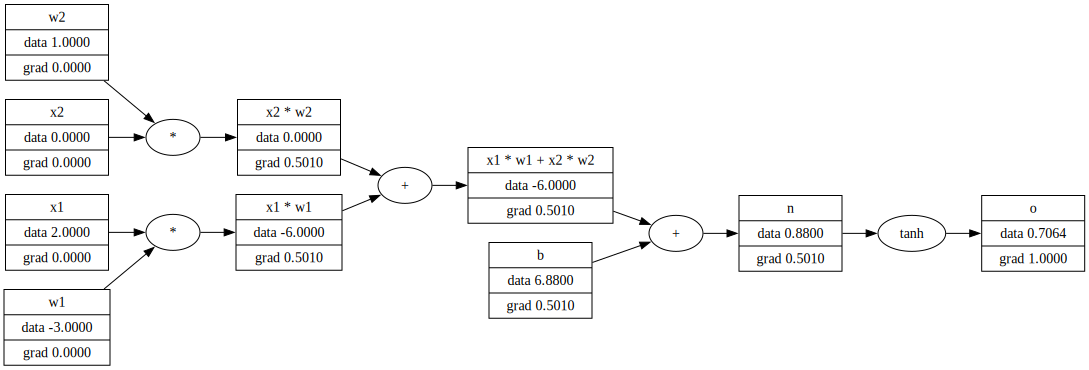

In [146]:
draw_dot(o)

In [150]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

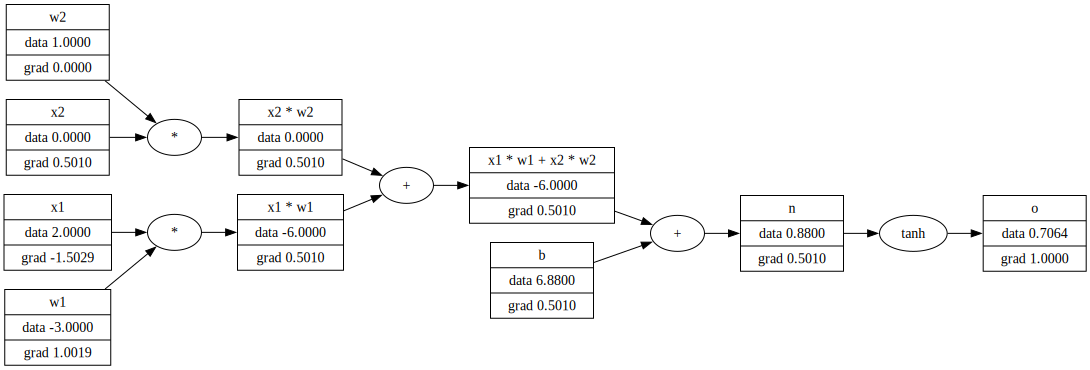

In [151]:
draw_dot(o)

In [158]:
o.grad = 1.0

In [159]:
o._backward()

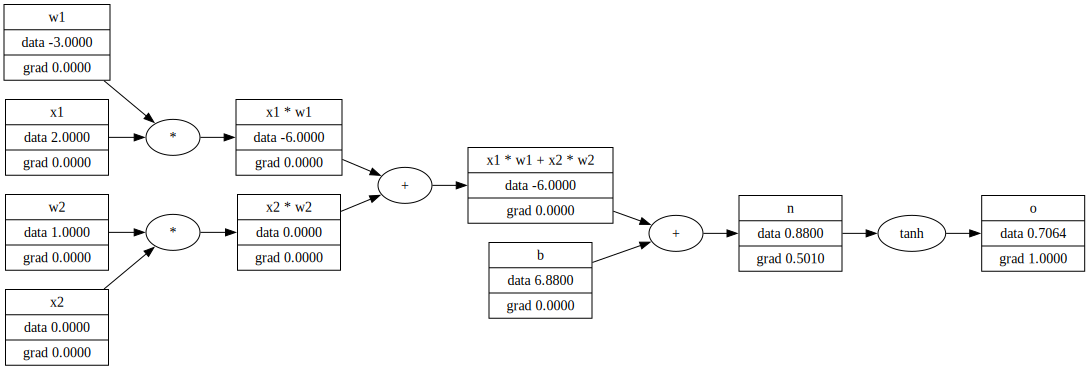

In [160]:
draw_dot(o)

In [161]:
n._backward()

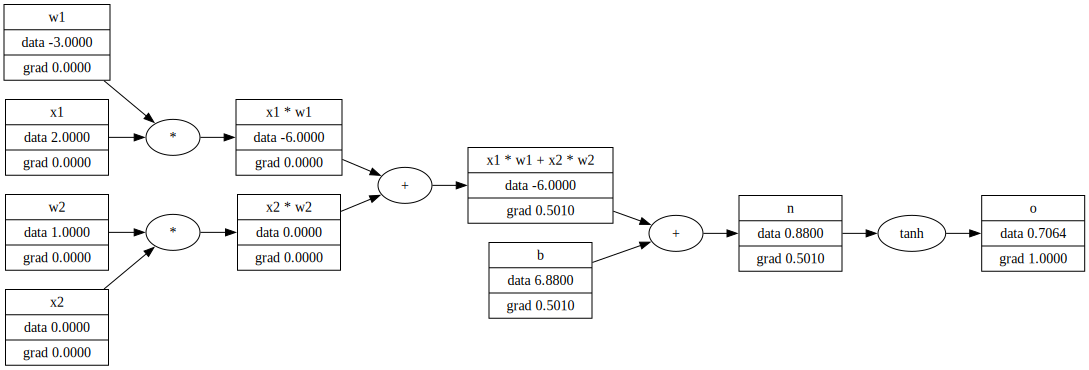

In [162]:
draw_dot(o)

In [163]:
b._backward()

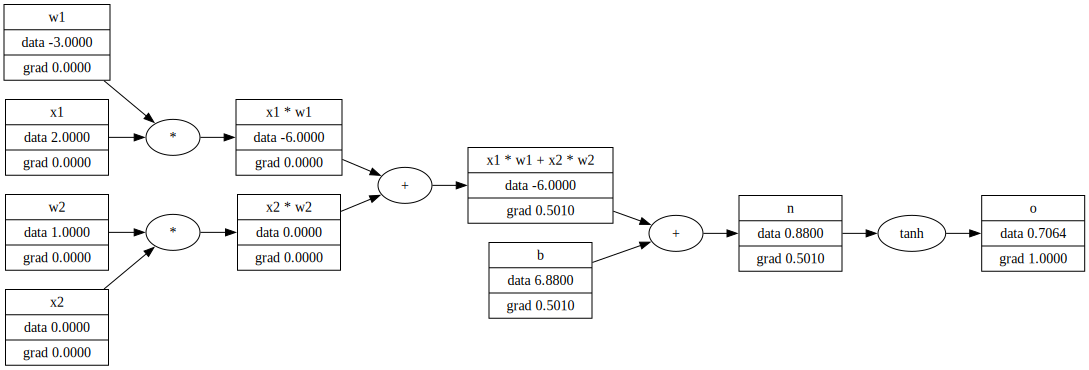

In [164]:
draw_dot(o)

In [165]:
x1w1x2w2._backward()

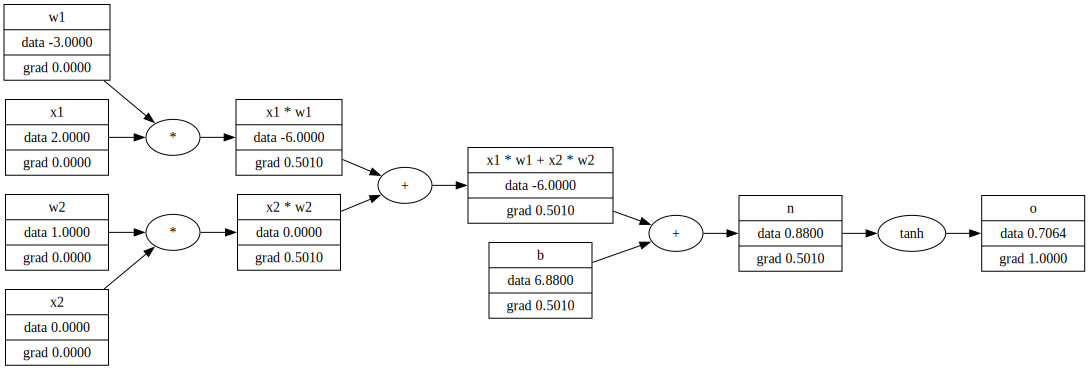

In [166]:
draw_dot(o)

In [167]:
x1w1._backward()

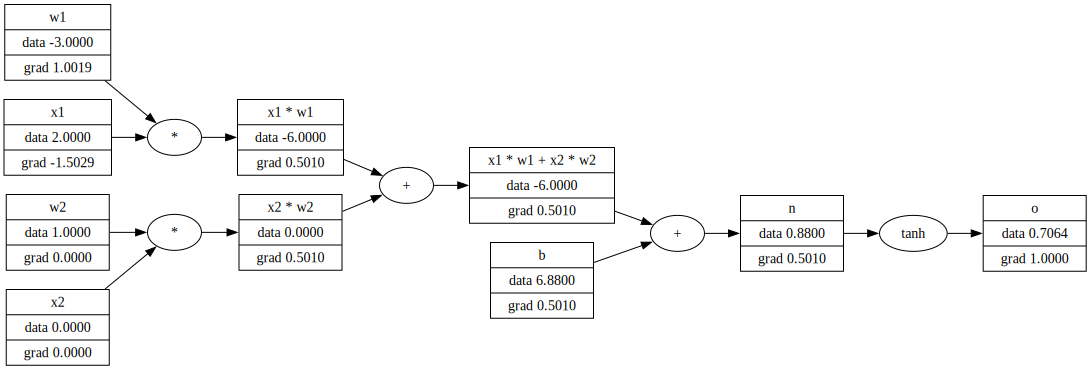

In [168]:
draw_dot(o)

In [169]:
w1._backward()

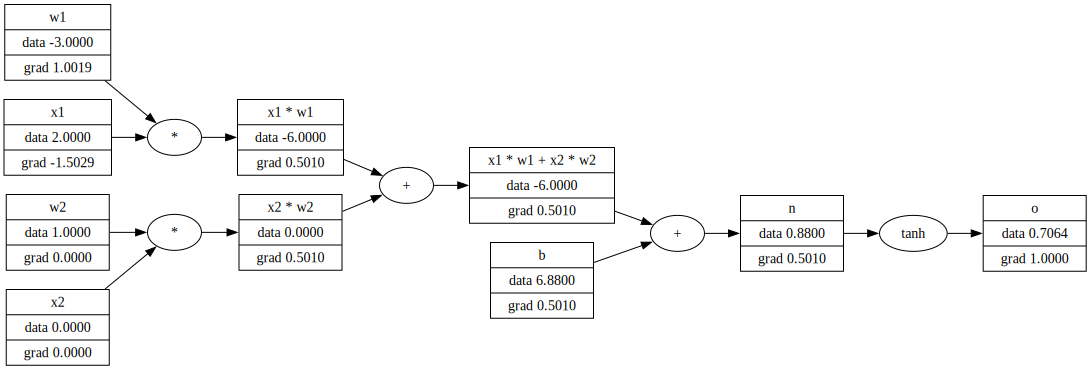

In [170]:
draw_dot(o)

In [171]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.88),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8799999999999999),
 Value(data=0.7064193203972352)]

In [172]:
for node in reversed(topo):
    node._backward()

In [175]:
o.backward()

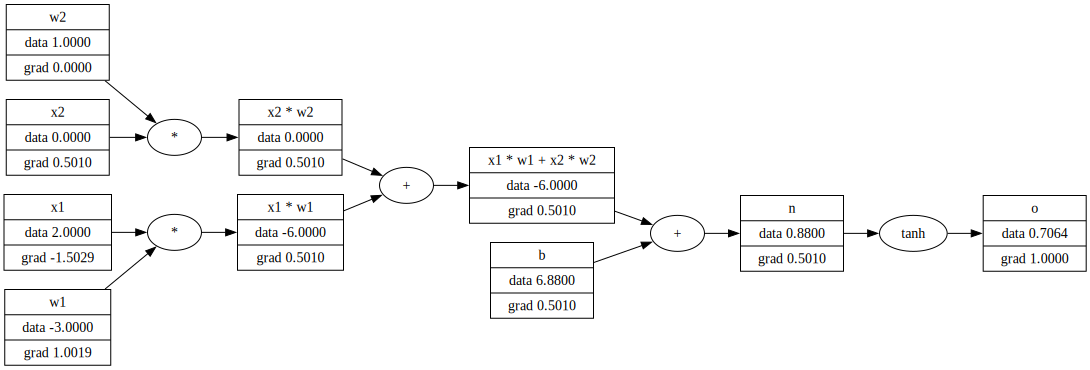

In [176]:
draw_dot(o)

In [186]:
o.backward()

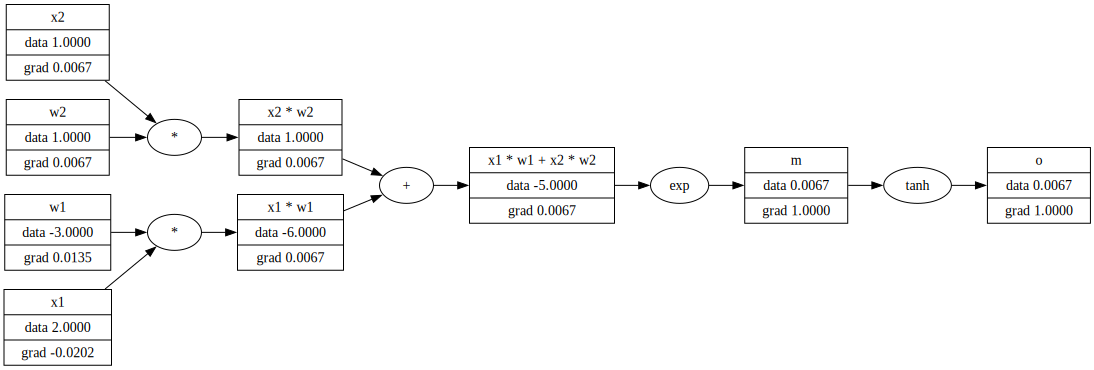

In [187]:
draw_dot(o)

In [366]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1,1))

    def __call__(self, x):
        x = [xi if isinstance(xi, Value) else Value(xi) for xi in x]
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.7251308743935911)

In [367]:
class Layer: # a layer is a list of neurons
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)] # create the list of neurons

    def __call__(self, x):
        outs = [n(x) for n in self.neurons] # evaluate activation of each neuron
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts # list of layer sizes/num neurons per layer
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # a layer is a set of neurons connected to another set of neurons

    def __call__(self, x):
        for layer in self.layers: # sequentially pass the data through each layer
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.3060628658103582)

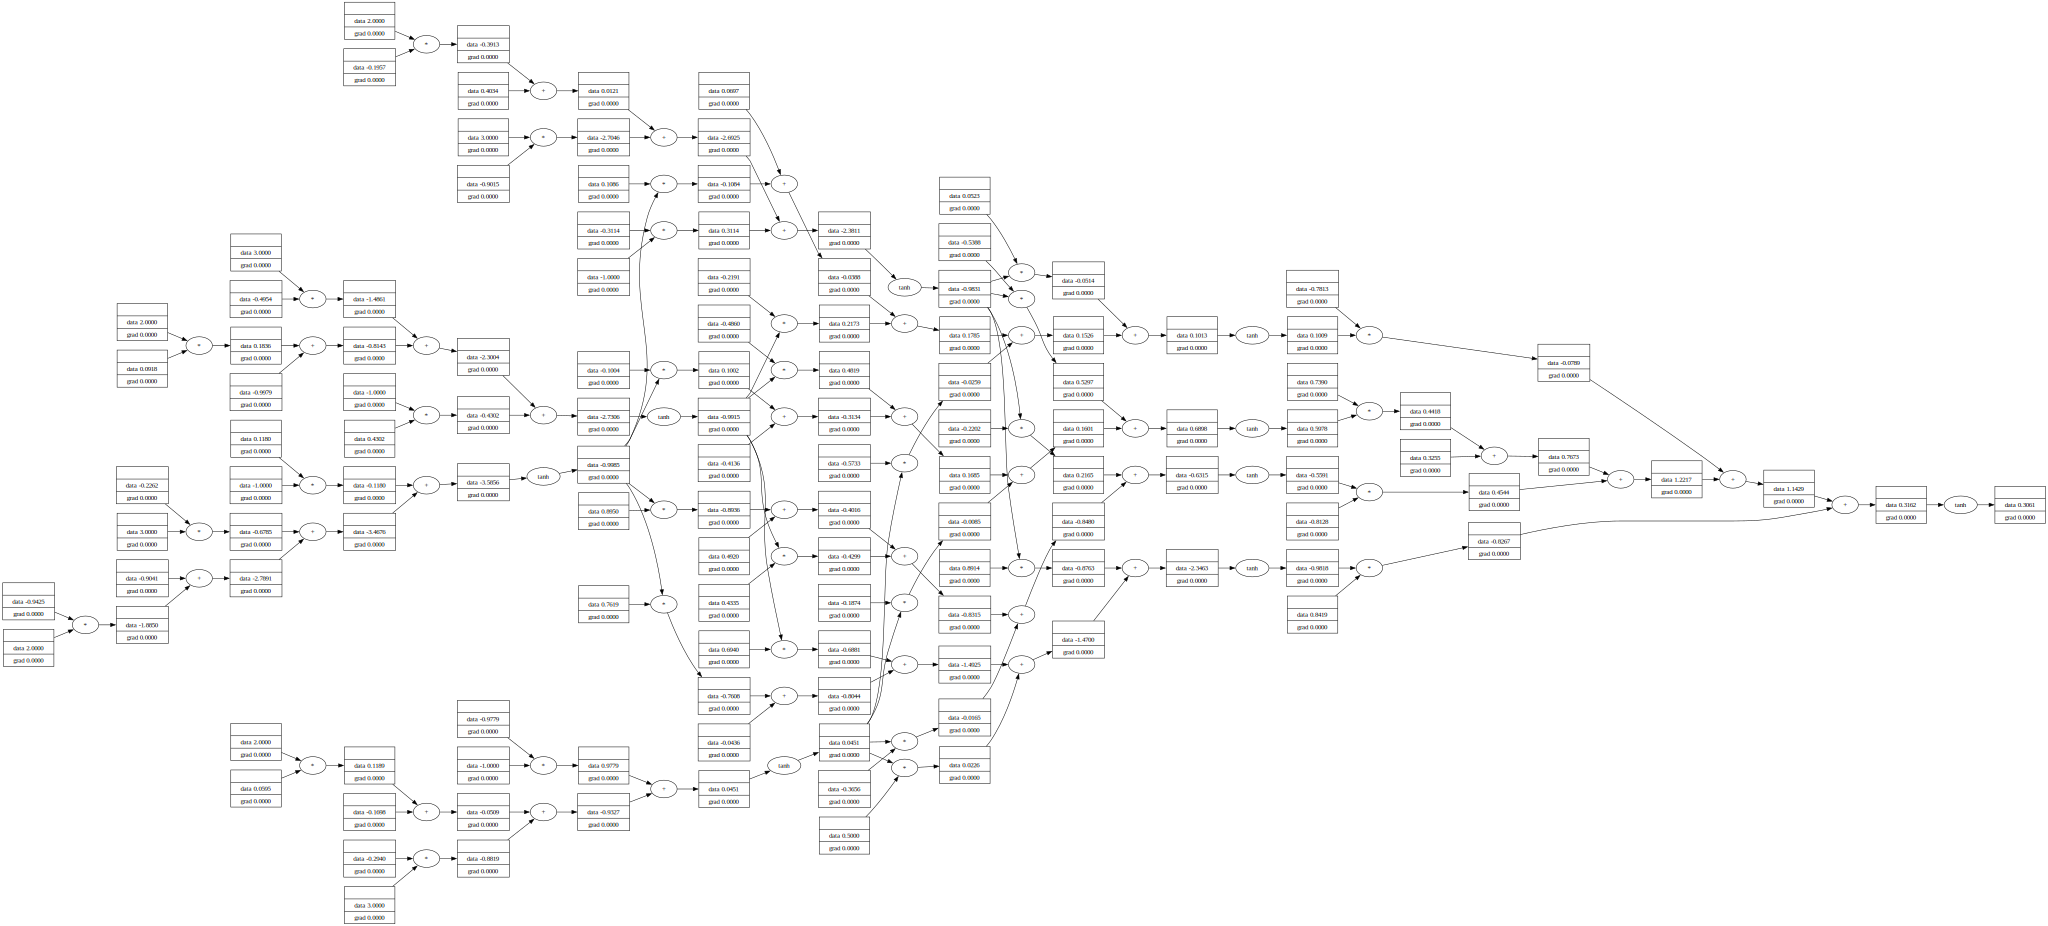

In [368]:
draw_dot(n(x))

In [369]:
xs = [
    [2., 3., -1.],
    [3., -1., 0.5],
    [0.5, 1., 1.],
    [1., 1., -1.]
]

ys = [1., -1., -1., 1.]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.3060628658103582),
 Value(data=-0.12885671615860922),
 Value(data=-0.3752196719120122),
 Value(data=0.4087761189757022)]

In [370]:
loss = sum([(yout - ygt)**2 for ygt,yout in zip(ys, ypred)])

In [371]:
loss

Value(data=1.9803355030484617)

In [372]:
loss.backward()

In [373]:
n.layers[0].neurons[0].w[0].grad

-0.06044119808225988

In [374]:
n.layers[0].neurons[0].w[0].data

-0.9425053233258855

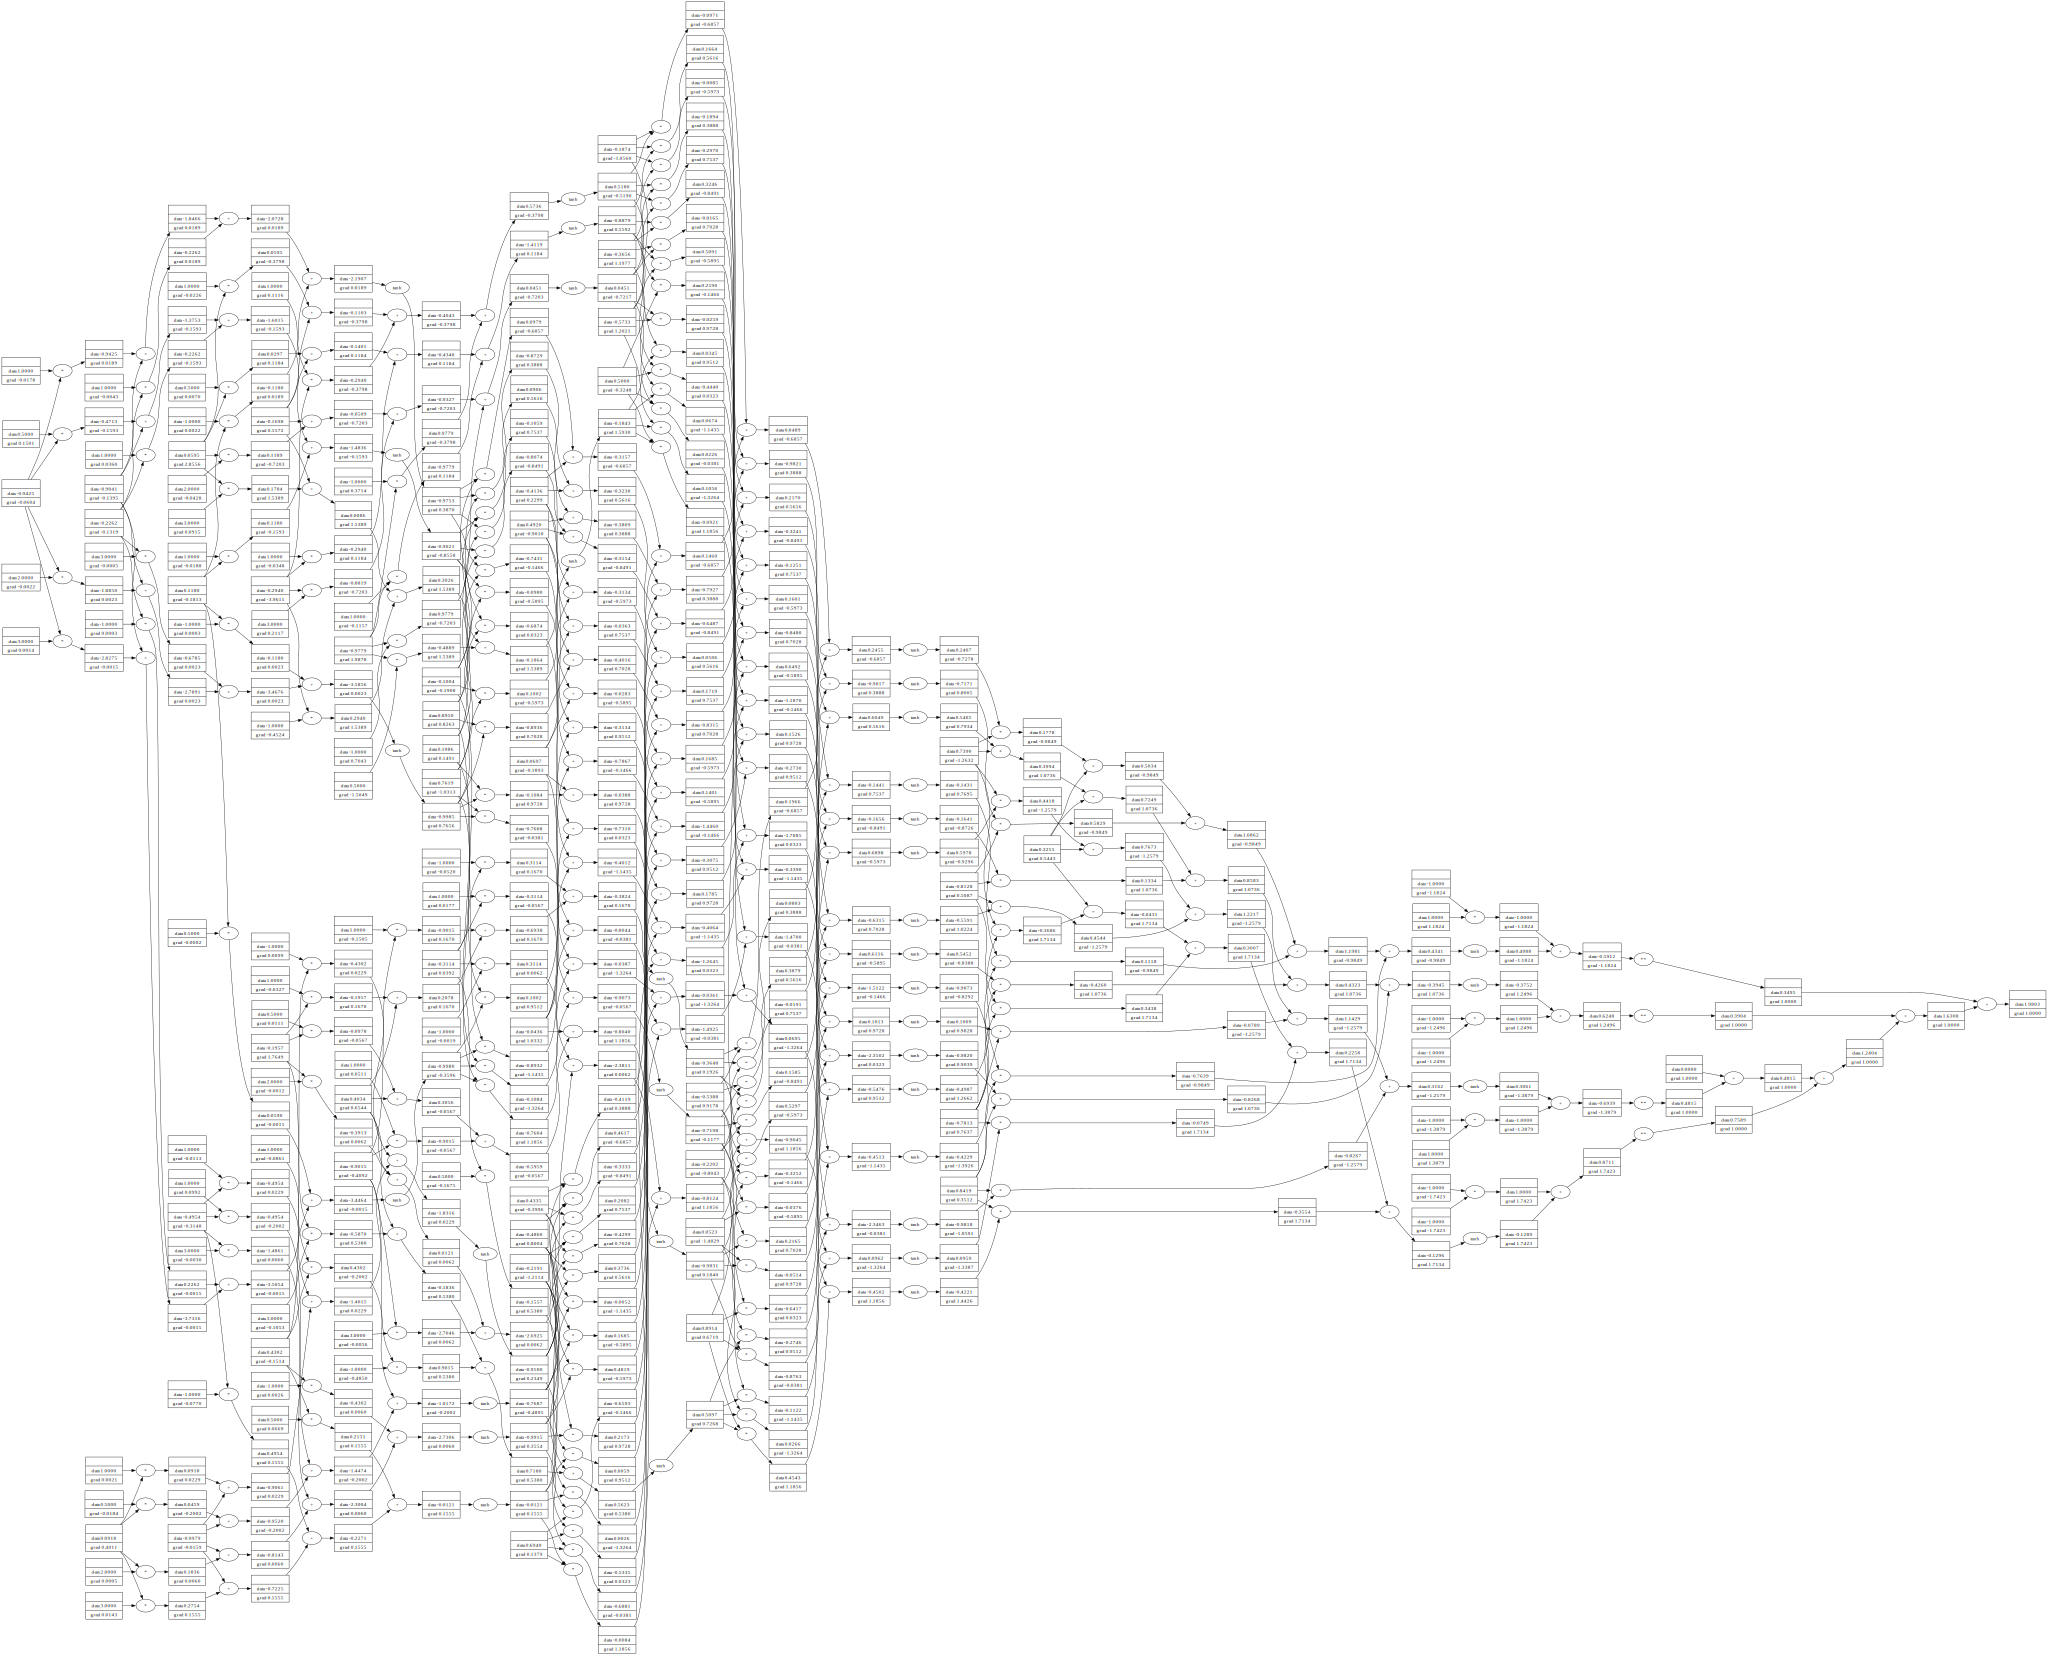

In [375]:
draw_dot(loss)

In [376]:
len(n.parameters())

41

In [377]:
loss.backward()

In [378]:
n.layers[0].neurons[0].w[0].grad

-1.298021710080409

In [379]:
n.layers[0].neurons[0].w[0].data

-0.9425053233258855

In [380]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [381]:
n.layers[0].neurons[0].w[0].grad

-1.298021710080409

In [382]:
n.layers[0].neurons[0].w[0].data

-0.9295251062250814

In [383]:
ypred = [n(x) for x in xs]
loss = sum((yout-ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.32767933300063423)

In [384]:
loss.backward()

In [385]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [386]:
ypred = [n(x) for x in xs]
loss = sum((yout-ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.16381582080976323)

In [387]:
ypred

[Value(data=0.9557931037920689),
 Value(data=-0.8981031964908216),
 Value(data=-0.6155270279558491),
 Value(data=0.9395091218482166)]

In [388]:
for _ in range(100):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))

    for p in n.parameters():
        p.grad = 0.0
    
    loss.backward()

    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(_, loss.data)

0 0.16381582080976323
1 0.0698200871896711
2 0.05035654649331156
3 0.04109717977364132
4 0.03558557883514507
5 0.0318756041059239
6 0.029168641921177213
7 0.027076605109042938
8 0.025388972331911296
9 0.023982198123288244
10 0.022779297515632985
11 0.02172994147080711
12 0.02079989095234719
13 0.01996504751756844
14 0.019207939401223128
15 0.01851556208842588
16 0.017878005864190277
17 0.017287557806625165
18 0.016738099012298058
19 0.016224690670877513
20 0.015743283913006653
21 0.015290512560396607
22 0.01486354250218972
23 0.014459960447521507
24 0.014077690513397224
25 0.013714930792288985
26 0.013370104466902396
27 0.013041821659655804
28 0.012728849304503277
29 0.012430087086460921
30 0.012144548023098063
31 0.011871342636053012
32 0.011609665927925249
33 0.011358786573151747
34 0.011118037872680824
35 0.010886810126462518
36 0.010664544155422277
37 0.010450725762965294
38 0.010244880970352489
39 0.010046571894170457
40 0.009855393160254383
41 0.00967096876874077
42 0.00949294934

In [389]:
ypred

[Value(data=0.9703557528256734),
 Value(data=-0.9910170110397358),
 Value(data=-0.9595635098089346),
 Value(data=0.9561802974671874)]